In [31]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

plt.rcParams['figure.figsize'] = (12, 9)

# Assignment 1

**IMPORTANT**: When finished all problems, rerun your entire notebook by clicking `Kernel > Restart Kernel and Run All Cells` to make sure your notebook runs correctly.

## 1. Sequential Labeling

In this problem, you will implement a system that labels objects in binary images and compute their geometric properties.

Let's first load our sample image and display it.

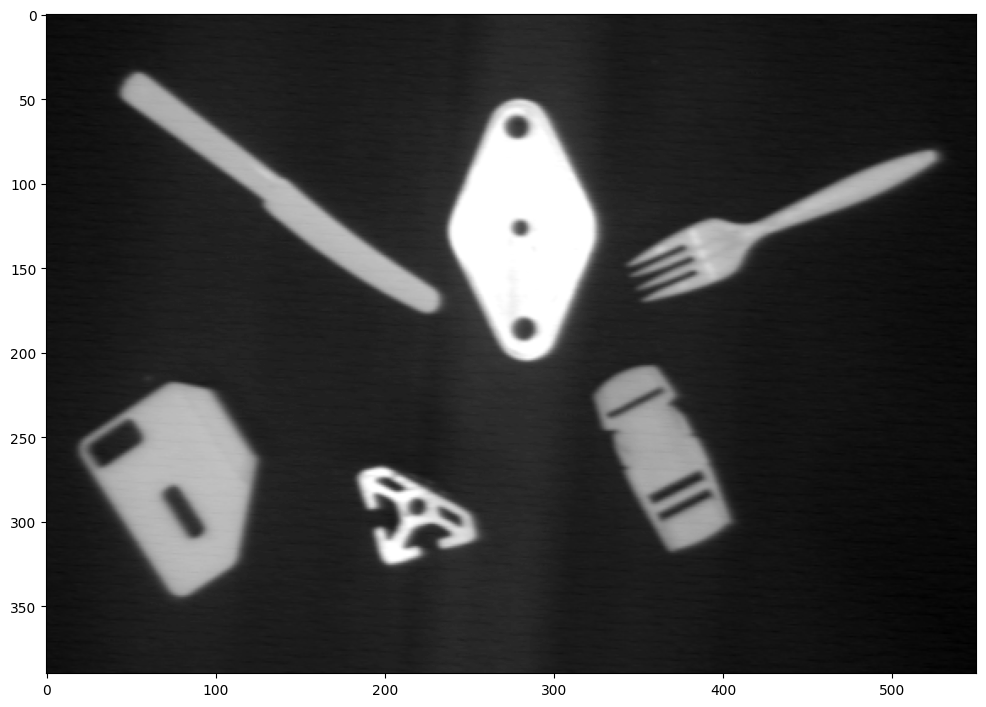

In [32]:
img = plt.imread('data/many_objects_2.png')

plt.imshow(img, cmap='gray')
plt.show()

### 1a. Image Binarization (10 points)

Implement the following function that converts a grayscale image to a binary one by thresholding the pixel intensities. Each element in the output array must be a Boolean value where `True` indicates that the intensity of the corresponding pixel in the input is greater than or equal to the threshold value. You should be able to implement this without using `for`-loops.

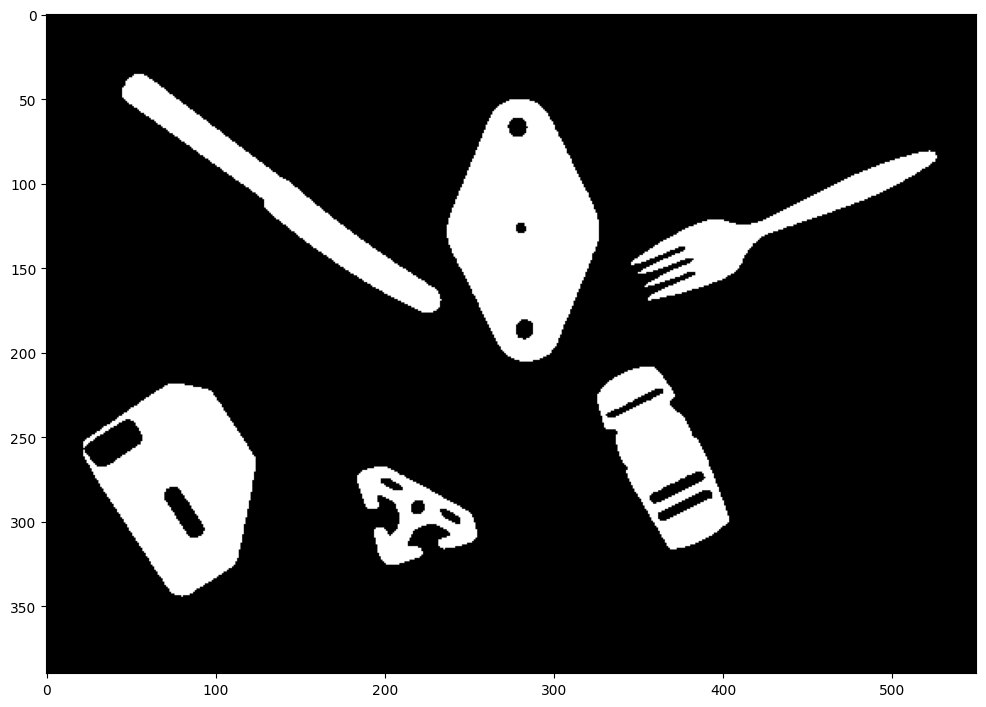

In [33]:
def binarize(gray_img, thresh_val):
    """Converts a grayscale image to a binary image by thresholding.
    
    Args:
    - gray_img: H x W array representing a grayscale image.
    - thresh_val: Threshold value.
    
    Returns:
    - binary_img: H x W Boolean array representing the thresholded image.
    """
    # Done!
    # create an empty array that has same shape of input gray image
    binary_img = np.empty_like(gray_img)
    # apply thresh_val
    binary_img[gray_img < thresh_val] = 0
    binary_img[gray_img >= thresh_val] = 1
    
    return binary_img

binary_img = binarize(img, thresh_val=0.5)

plt.imshow(binary_img, cmap='gray')
plt.show()

### 1b. Label Connected Regions (30 points)

Implement the sequential labeling algorithm in the following function. The function takes a binary image as input and returns an array of the same size. The output array should have data type `int`, where each element is an object label. For example, all background pixels have value 0, all pixels of object 1 has value 1, etc.

Recall from the slides that you may want to do the labeling in two passes. In the first pass, pixels are assigned labels based on the labels of their neighbors. (Be careful when handling pixels near the image boundaries.) This labeling process may result in the same area having multiple labels, which is resolved in the second pass. You are free to choose how to resolve equivalent labels. The union-find data structure is especially suitable for this purpose. If you want to implement helper classes or functions, feel free to add them outside the function body.

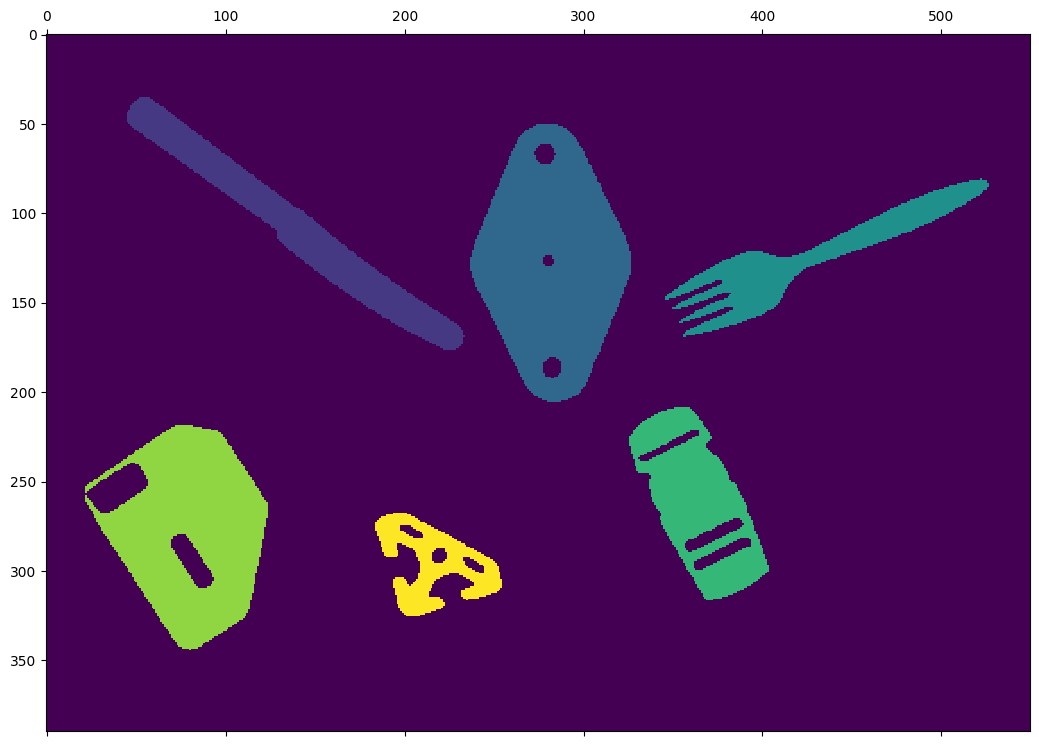

Found 6 objects in image.


In [34]:
def label(binary_img):
    """Label disconnected regions in a binary image.
    
    Args:
    - binary_img: H x W Boolean array representing a binary image where `False`
        indicates background while `True` indicates object regions.
    
    Returns:
    - label_img: H x W int array representing an image with labeled object
        regions where 0 indicates the background while other values represent
        object labels.
    """
    # Done
    label_img = np.zeros_like(binary_img, dtype=np.int64)
    label_map = np.zeros_like(binary_img, dtype=np.int64)
    label_val = 0
    equal_list = {}
    # first pass
    for i in range(label_img.shape[0]):
        for j in range(label_img.shape[1]):
            if binary_img[i, j] == 0:
                pass
            else:
                dig_i, dig_j = check_pos(label_img, i-1, j-1)
                top_i, top_j = check_pos(label_img, i-1, j) 
                left_i, left_j = check_pos(label_img, i, j-1)
                if label_map[dig_i, dig_j] == 0 and label_map[top_i, top_j] == 0 and label_map[left_i, left_j] == 0:
                    label_val += 1
                    equal_list[str(label_val)] = label_val
                    label_img[i, j] = label_val
                    label_map[i, j] = 1
                elif label_map[dig_i, dig_j] == 1 and label_map[top_i, top_j] == 0 and label_map[left_i, left_j] == 0:
                    label_map[i, j] = 1
                    label_img[i, j] = label_img[dig_i, dig_j]
                elif label_map[top_i, top_j] == 1 and label_map[left_i, left_j] == 0:
                    label_map[i, j] = 1
                    label_img[i, j] = label_img[top_i, top_j]
                elif label_map[top_i, top_j] == 0 and label_map[left_i, left_j] == 1:
                    label_map[i, j] = 1
                    label_img[i, j] = label_img[left_i, left_j]
                elif label_map[top_i, top_j] == 1 and label_map[left_i, left_j] == 1:
                    if label_img[top_i, top_j] == label_img[left_i, left_j]:
                        label_map[i, j] = 1
                        label_img[i, j] = label_img[left_i, left_j]
                    else:
                        label_map[i, j] = 1
                        label_img[i, j] = np.min([label_img[top_i, top_j], label_img[left_i, left_j]])
                        equal_list[str(np.max([label_img[top_i, top_j], label_img[left_i, left_j]]))] = np.min([label_img[top_i, top_j], label_img[left_i, left_j]])
    
    # second pass
    for i in range(label_img.shape[0]):
        for j in range(label_img.shape[1]):
            if label_img[i, j] == 0:
                pass
            else:
                label_img[i, j] = find_min(equal_list, label_img[i, j])
    
    # redefine the label values
    obj_count = len(np.unique(label_img))
    labels = np.unique(label_img)
    for i in range(obj_count):
        if labels[i] != i:
            label_img[label_img == labels[i]] = i                    
    
    return label_img

# function to find minimum value of equivalent set of labels
def find_min(equal_list, val):
    if equal_list[str(val)] == val:
        return val
    
    return find_min(equal_list, equal_list[str(val)])

# function to handle all position cases
def check_pos(label_img, i, j):
    if i < 0:
        i_d = i + 2
    elif i  >= label_img.shape[0]:
        i_d = i - 2
    else:
        i_d = i
    
    if j < 0:
        j_d = j + 2
    elif j >= label_img.shape[1]:
        j_d = j - 2
    else:
        j_d = j
    
    return i_d, j_d 

label_img = label(binary_img)
plt.matshow(label_img)
plt.show()

obj_count = len(np.unique(label_img)) - 1
print(f"Found {obj_count} objects in image.")

### 1c. Calculate Geometric Attributes (10 points)

In the cell below, calculate the geometric attributes (center, orientation, second moment) of each object. A code snippet has been provided to visualize these attributes. To be specific, for each object, we mark the center of the object, and draws an ellipse having the same orientation and second moments around the center.

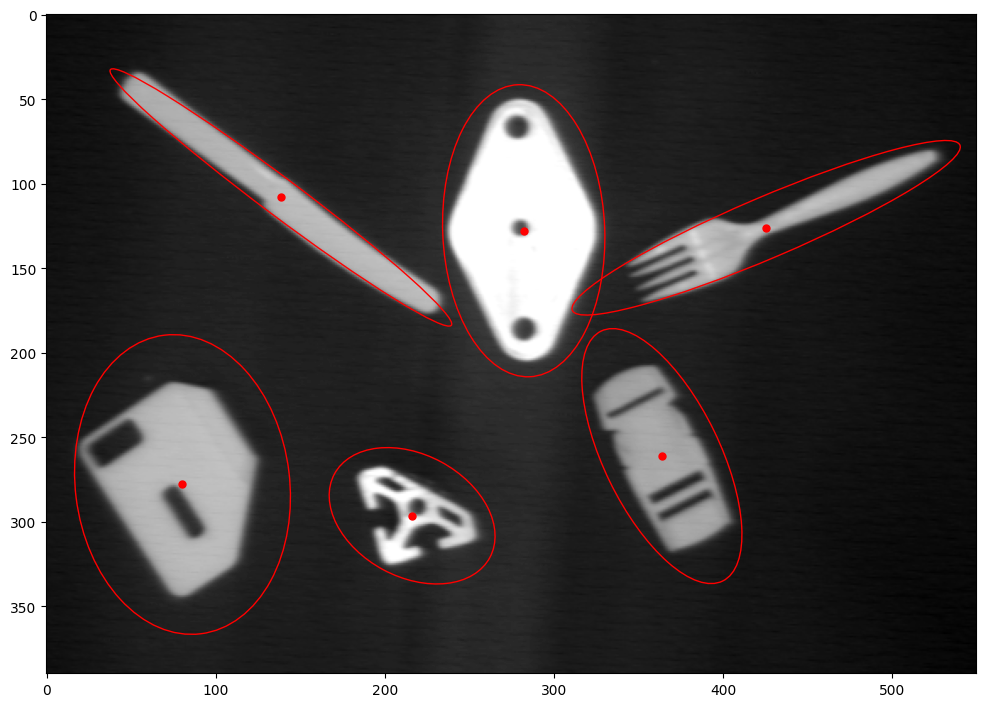

In [35]:
from matplotlib.patches import Ellipse

def calculate_geometric_attributes(label_img, label):
    """Find the geometric attributes of an object in a labeled image.
    
    The origin of the coordinate system is at the top left corner of the image.
    The x axis points to the right. The y axis points down.
    
    Args:
    - label_img: H x W int array representing an image with labeled object
        regions where 0 indicates the background while other values represent
        object labels.
    - label: Label of the object for which we want to calculate the geometric
        attributes.
        
    Returns:
    - cx, cy: xy coordinates of the object center.
    - theta: Orientation of the object in radians.
    - emin, emax: Second moments of the object.
    """
    # Done
    label_area = np.sum(label_img[label_img == label])
    pos_i, pos_j = np.where(label_img == label)
    cx = 0
    cy = 0
    theta = 0
    emin = 0
    emax = 0
    # compute the center of the object
    for i in range(pos_i.shape[0]):
        cx += pos_j[i] * label_img[pos_i[i], pos_j[i]]
        cy += pos_i[i] * label_img[pos_i[i], pos_j[i]] 
    cx /= label_area
    cy /= label_area
    a = b = c = 0
    # compute orientation of the object
    for i in range(pos_i.shape[0]):
        x_prim = pos_j[i] - cx
        y_prim = pos_i[i] - cy
        a += (x_prim ** 2) * label_img[pos_i[i], pos_j[i]]
        b += (x_prim * y_prim) * label_img[pos_i[i], pos_j[i]]
        c += (y_prim ** 2) * label_img[pos_i[i], pos_j[i]]
    b *= 2
    # get two solutions of orientation by first derivative
    theta1 = math.atan2(b, a-c) / 2
    theta2 = theta1 + (math.pi / 2)
    theta = theta1
    # get minimum and maximum second moment by second derivative
    emin = a * (math.sin(theta1) ** 2) - b * math.sin(theta1) * math.cos(theta1) + c * (math.cos(theta1) ** 2)
    emax = a * (math.sin(theta2) ** 2) - b * math.sin(theta2) * math.cos(theta2) + c * (math.cos(theta2) ** 2)
    return cx, cy, theta, emin, emax

  
plt.imshow(img, cmap='gray')
labels = [l for l in np.unique(label_img) if l]
for label in labels:
    cx, cy, t, e1, e2 = calculate_geometric_attributes(label_img, label)
    # Visualization.
    # Plot the center of the area.
    plt.plot(cx, cy, marker='o', markersize=5, color=(1,0,0))
    # Plot an ellipse having the same orientation and second moments as the area.
    ew = 2 * ((4/np.pi)**(1/4)) * (e1**(-1/8)) * (e2**(3/8))
    eh = ew * np.sqrt(e1 / e2)
    plt.gca().add_patch(Ellipse((cx, cy), ew, eh, t*180/np.pi,
        facecolor='none', edgecolor=(1,0,0), linewidth=1))
plt.show()


## 2. Hough Transform

In this example you will implement the Hough transform to find coins in the sample image below.

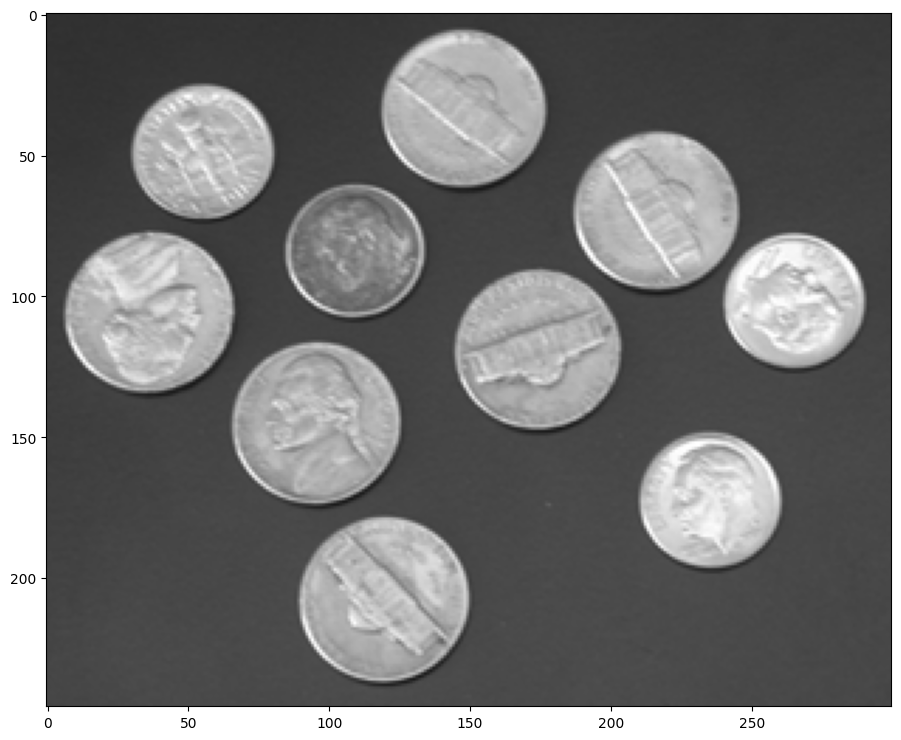

In [36]:
img = cv2.imread('data/coins.png')
plt.imshow(img, cmap='gray')
plt.show()

### 2a. Edge Detection (10 points)

Detect edges in the sample image. Since you have implemented edge detection from scratch in the weekly notebook, here you can simply call `cv2.Canny()`. Pick your threshold values carefully so the edges of the coins are detected.

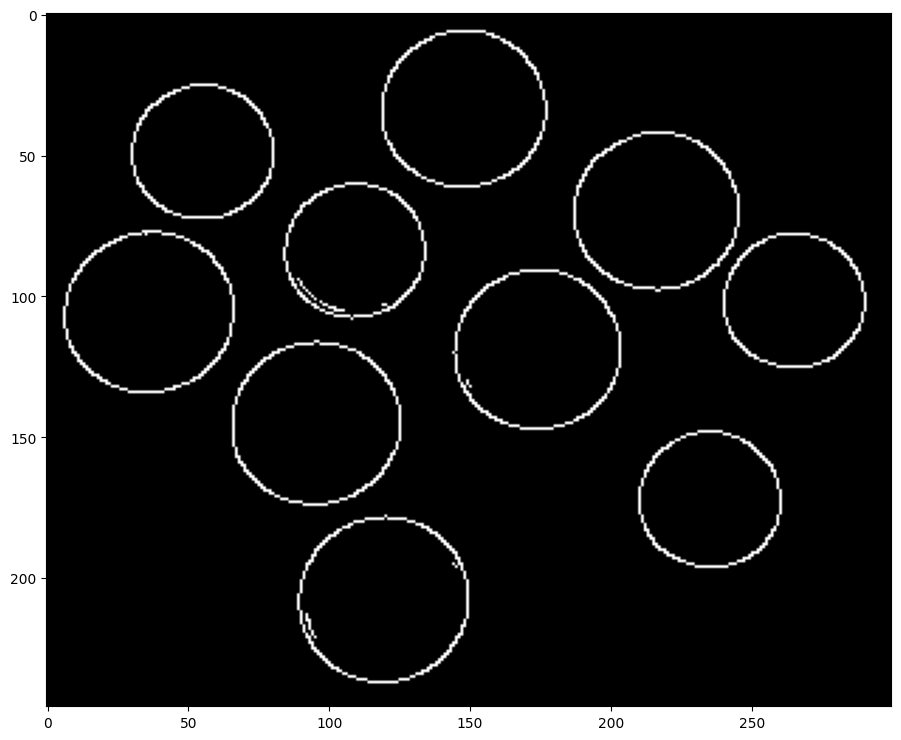

In [37]:
edge_img = cv2.Canny(img, 250, 650)# Detect edge of the coins
plt.imshow(edge_img, cmap='gray')
plt.show()

### 2b. Hough Transform (30 points)

Implement the following function to detect circles using the Hough transform. The function should return the accumulator array instead of a list of circles.

For simplicity, your implementation can assume that all circles will be fully inside the image and will not be clipped by the image boundary.

In [38]:
def hough_circles(edge_img, radii):
    """Find circles in an image containing edge pixels.
    
    Args:
    - edge_img: H x W uint8 edge image where 0 indictes non-edge pixels
        whereas 255 indicates edge pixels.
    - radii: A list of R radius values. Only circles whose radius is in this
        list will be found.
    
    Returns:
    - score_map: R x W x H accumulator array. `score_map[r_idx, y, x]`
        represents the total votes received by the circle of radius
        radii[r_idx] centered at pixel `edge_img[y, x]`.
    """
    # Done
    score_map = np.zeros((len(radii), edge_img.shape[0], edge_img.shape[1]))
    for i in range(len(radii)):
        r = radii[i]
        for y in range(edge_img.shape[0]):
            for x in range(edge_img.shape[1]):
                # for each edge pixel
                if edge_img[y, x] > 0:
                    # check if which center of raw image locates on the circle centered at edge pixel
                    for theta in range(0, 360):
                        theta_pi = theta * math.pi / 180
                        a = int(y - r * math.sin(theta_pi))
                        b = int(x - r * math.cos(theta_pi))
                        if a >= 0 and b >= 0 and a < edge_img.shape[0] and b < edge_img.shape[1]:
                            score_map[i, a, b] += 1
                        
    return score_map

radii = np.arange(25., 31.)
score_map = hough_circles(edge_img, radii)

Visualize the score map (accumulator array) corresponding to `radii[0]`.

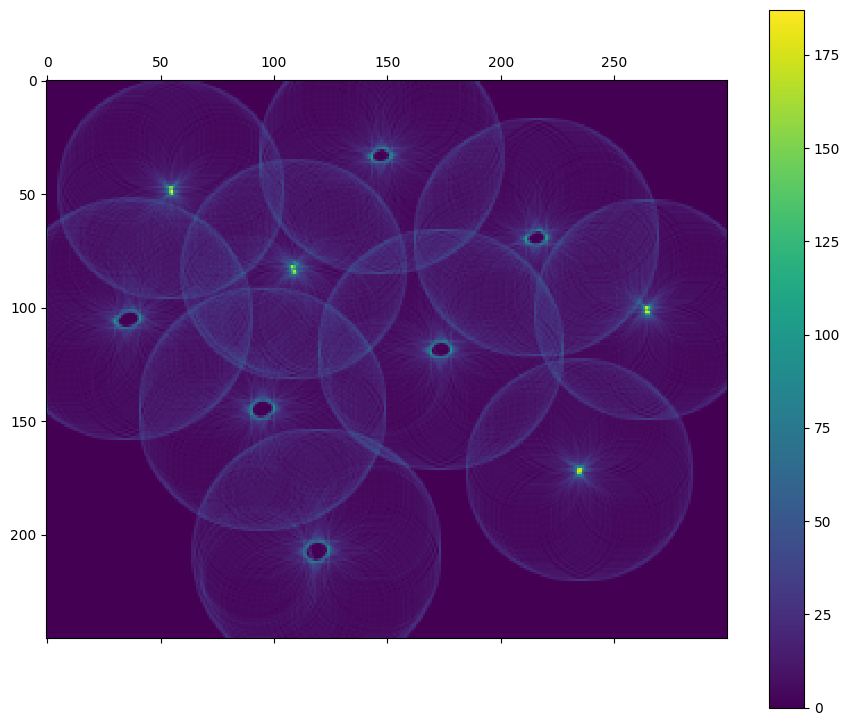

In [39]:
plt.matshow(score_map[0])
plt.colorbar()
plt.show()

From the accumulator array, pick the top scoring circles and display them. It is fine (and expected) if you detect multiple circles for a single coin. We will address this in the next section.

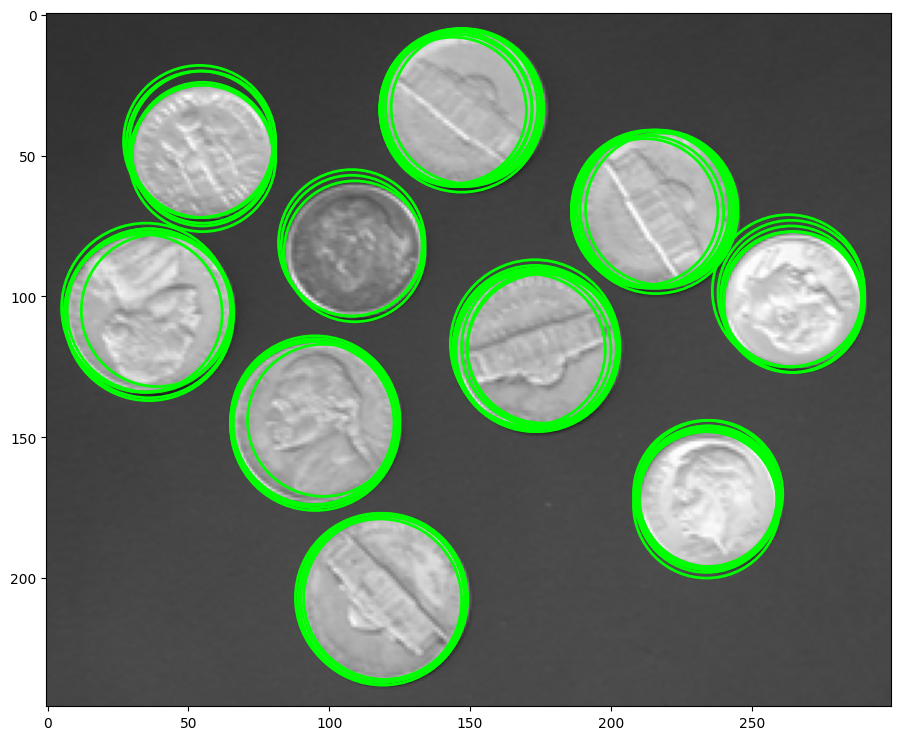

In [40]:
from matplotlib.patches import Circle

def pick_circle(score_map):
    ris = []
    ys = []
    xs = []
    for i in range(score_map.shape[0]):
        score = score_map[i, :, :]
        high_y, high_x = np.where(score >= np.unique(score)[-10])
        for j in range(high_y.shape[0]):
            ris.append(i)
            ys.append(high_y[j])
            xs.append(high_x[j])
    
    return ris, ys, xs

plt.imshow(img, cmap='gray')
ris, ys, xs = pick_circle(score_map) # Done
for ri, y, x in zip(ris, ys, xs):
    r = radii[ri]
    plt.gca().add_patch(Circle((x, y), r, facecolor='none', edgecolor=(0,1,0), linewidth=2))

plt.show()

### 2c. Non-Maximum Suppression (10 points)

You may have observed that your results in the last section contain duplicate detections if you want to detect all coins. This is quite common in detection systems including the neural network detectors that we will cover in the second half of this course. A post-processing step called non-maximum suppression is often needed to remove these duplicate detections. In our case, if two circles overlap with each other too much, we can assume they are duplicate detections and discard the one with lower votes. For the entire list of detections, we could sort them based on votes and repeat this process to suppress duplicate detections.

In the cell below, implement this process and plot the results after post-processing. The final results should contain all coins without duplicates.

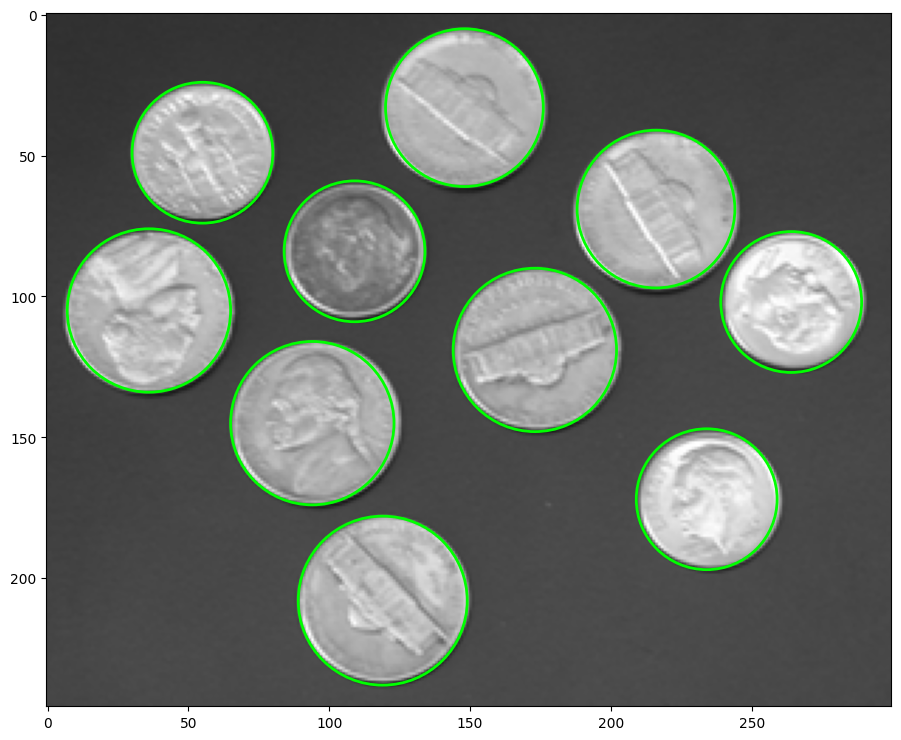

In [41]:
# Done
# function to sort the score of circles
def sortScore(elem):
    return elem[3]

def nonmax_suppress(ris, ys, xs, score_map):
    riis = ris.copy()
    yys = ys.copy()
    xxs = xs.copy()
    for j in range(len(ys)-1):
        score = [(ris[j], ys[j], xs[j], score_map[ris[j], ys[j], xs[j]])]
        for k in range(j+1, len(ys)):
            dist = np.sqrt((ys[j] - ys[k]) ** 2 + (xs[j] - xs[k]) ** 2)
            if dist <= 10:
                score.append((ris[k], ys[k], xs[k], score_map[ris[k], ys[k], xs[k]]))
        if (len(score) <= 1):
            pass
        else:
            score.sort(key=sortScore)
            for i in range(len(score)-1):
                if score[i][1] in yys and score[i][2] in xxs:
                    loc_y = np.where(yys == score[i][1])
                    for j in range(len(loc_y[0])):
                        if xxs[loc_y[0][j]] == score[i][2]:
                            yys.pop(loc_y[0][j])
                            xxs.pop(loc_y[0][j])
                            riis.pop(loc_y[0][j])
                            break

    
    return riis, yys, xxs

plt.imshow(img, cmap='gray')
riiis, yyys, xxxs = nonmax_suppress(ris, ys, xs, score_map) # Done

for rii, yy, xx in zip(riiis, yyys, xxxs):
    r = radii[rii]
    plt.gca().add_patch(Circle((xx, yy), r, facecolor='none', edgecolor=(0,1,0), linewidth=2))

plt.show()
